### chen2016 for HVG selection <br>
https://doi.org/10.1186/s12864-016-2897-6

In [1]:
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.optimize import least_squares
from scipy.stats import gaussian_kde
from scipy.stats import norm

In [2]:
ada = sc.datasets.pbmc3k()
ada

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
sc.pp.normalize_total(ada, target_sum=1e6)
data_norm = csr_matrix.toarray(ada.X).T
data_norm = pd.DataFrame(data_norm)
data_norm.shape

(32738, 2700)

In [4]:
def p_adjust_bh(p):
    """The Benjamini-Hochberg p-value correction for multiple hypothesis testing.
    Parameters
    ----------
    p : `list`
        A list of p-values.
    References
    ----------
    .. [1] Benjamini & Hochberg (1995) Controlling the false discovery rate: a practical
        and powerful approach to multiple testing.  J Royal Statistical Society, Series B
    Returns
    -------
    int
        Adjusted p-values.
    """
    p = np.asfarray(p)
    p = np.ma.array(p, mask=np.isnan(p)) # to handle nan
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(float(len(p)), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    q = q[by_orig]
    q[np.isnan(p.data)] = np.nan # put nan back
    return q.data

In [5]:
def chen2016(data_norm, plot = False, fdr = 0.1, ngenes = 1000): #df: features*cells, normalized raw count (not log transform)
    avg = data_norm.mean(axis=1)
    norm_data = data_norm[avg > 0]
    rows = data_norm.shape[0] #features
    avg = data_norm.mean(axis=1)
    std = data_norm.std(axis=1)
    cv = std / avg

    xdata = avg #raw
    ydata = np.log10(cv) #log
    r = np.logical_not(ydata.isna())
    ydata = np.array(ydata[r]) #Y
    xdata = np.array(xdata[r]) #X
    
    #poly fit: log-log
    z = np.polyfit(np.log10(xdata), ydata, 2) 

    def predict(z, x):
        return z[0]*(x**2) + z[1]*x + z[2]

    xSeq_log = np.arange(min(np.log10(xdata)), max(np.log10(xdata)), 0.005) 
    ySeq_log = predict(z, xSeq_log)  #predicted y
    
    #start point for fit
    #plt.hist(np.log10(xdata), bins=100)
    def h(i):
        a = np.log10(xdata) >= (xSeq_log[i] - 0.05)
        b = np.log10(xdata) < (xSeq_log[i] + 0.05)
        return np.sum((a & b))
    
    gapNum = [h(i) for i in range(0, len(xSeq_log))] #density histogram of xdata
    cdx = np.nonzero(np.array(gapNum) > rows*0.005)[0] #start from high density bin

    xSeq = 10 ** xSeq_log 
    
    #end pointy for fit
    yDiff = np.diff(ySeq_log, 1) #a[i+1] - a[i]
    ix = np.nonzero((yDiff > 0) & (np.log10(xSeq[0:-1]) > 0))[0] # index of such (X, Y) at lowest Y

    if len(ix) == 0:
        ix = len(ySeq_log) - 1 # use all
    else:
        ix = ix[0]
    
    #subset data for fit
    xSeq_all = 10**np.arange(min(np.log10(xdata)), max(np.log10(xdata)), 0.001) 
    xSeq = xSeq[cdx[0]:ix]
    ySeq_log = ySeq_log[cdx[0]:ix]

    #lst fit
    def residuals(coeff, t, y):
        return y - 0.5 * (np.log10(coeff[1]/t + coeff[0])) # x: raw mean y:log(cv)

    x0 = np.array([0, 1], dtype=float) # initial guess a=0, b=1
    model = least_squares(residuals, x0, loss='soft_l1', f_scale= 0.01, args=(xSeq, ySeq_log))
     
    def predict_robust(coeff, x):
        return 0.5 * (np.log10(coeff[1]/x + coeff[0]))
     
    #stat test
    ydataFit = predict_robust(model.x, xSeq_all)
    logX = np.log10(xdata)
    logX = np.asarray(logX)
    logXseq = np.log10(xSeq_all)

    cvDist = [] #CV difference
    for i in range(0, len(logX)):
        cx = np.nonzero((logXseq >= (logX[i] - 0.2)) & (logXseq < (logX[i] + 0.2)))[0]

        tmp = np.sqrt((logXseq[cx] - logX[i])**2 + (ydataFit[cx] - ydata[i])**2) #distance
        tx = np.argmin(tmp)
        if logXseq[cx[tx]] > logX[i]:
            if ydataFit[cx[tx]] > ydata[i]:
                cvDist.append(-1*tmp[tx])
            else:
                cvDist.append(tmp[tx])
        elif logXseq[cx[tx]] <= logX[i]:
            if ydataFit[cx[tx]] < ydata[i]:
                cvDist.append(tmp[tx])
            else:
                cvDist.append(-1*tmp[tx])
            
    cvDist = np.log(10**np.array(cvDist)) #to natural log
    dor = gaussian_kde(cvDist)
    dor_y = dor(cvDist)
    distMid = cvDist[np.argmax(dor_y)]
    dist2 = cvDist - distMid
    a = dist2[dist2 <= 0]
    b = abs(dist2[dist2 < 0])
    c = distMid
    tmpDist = np.concatenate((a, b))
    tmpDist = np.append(tmpDist, c)
    
    # estimate mean and sd using maximum likelihood 
    distFit = norm.fit(tmpDist)
    pRaw = 1-norm.cdf(cvDist, loc=distFit[0], scale=distFit[1])
    pAdj = p_adjust_bh(pRaw)
    res = pd.DataFrame({'gene':ada.var_names[norm_data.index], 'gene_index': norm_data.index, 'pvalue' : pRaw, 'padj' : pAdj})
    #'gene_index': orig index of adata
    res = res.sort_values(by='pvalue')
    
    HVGs = res[res['padj'] < fdr]['gene']
    HVG = list(HVGs[:ngenes])
    print('HVG:', HVG)
          
    if plot:
        y_predict = predict_robust(model.x, xSeq) 
        plt.figure(figsize=(6, 5), dpi=120)
        
        plt.scatter(np.log10(xdata), ydata, s=3, marker='o') # orig
        plt.plot(np.log10(xSeq), ySeq_log, c='black', label='poly fit') # poly fit
        plt.plot(np.log10(xSeq), y_predict, label='robust lsq', c='r') # robust nonlinear
        
        ind = list(res[res['padj'] < fdr].index)[:ngenes] # index for filtered xdata, ydata
        for n, i in zip(HVG, ind):
            plt.annotate(n, xy = (np.log10(xdata)[i], ydata[i]), xytext = (np.log10(xdata)[i]+1, ydata[i]+0.5),
                         arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        plt.xlabel('log10(mean)')
        plt.ylabel('log10(CV)')
        plt.legend(loc='lower left')
        plt.show()
        
    
    return res[:ngenes]

HVG: ['SMARCA4', 'GNG11', 'RBM5', 'ABHD17B', 'GJC3', 'HEMK1', 'YPEL2', 'CDKN2A', 'EID2', 'CTB-152G17.6']


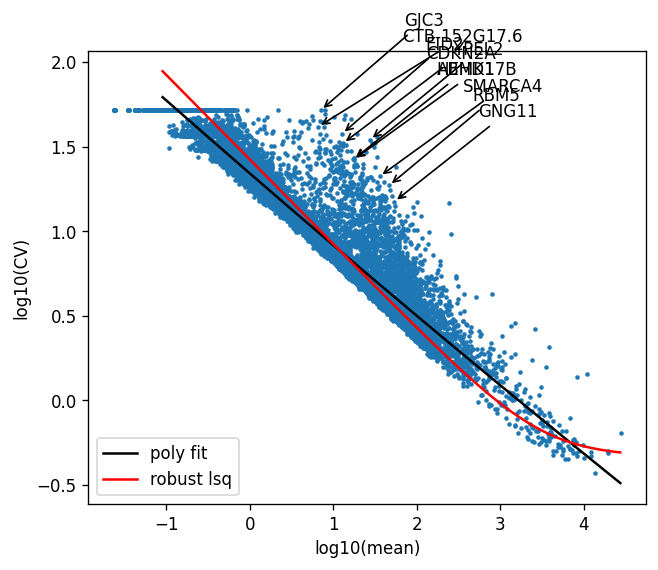

,gene,gene_index,pvalue,padj
15060,SMARCA4,29831,0.0,0.0
6364,GNG11,12534,0.0,0.0
3158,RBM5,5897,0.0,0.0
8023,ABHD17B,16078,0.0,0.0
6404,GJC3,12604,0.0,0.0


In [6]:
res = chen2016(data_norm, plot = True, fdr = 0.1, ngenes = 10)
res.head()

In [7]:
ada_selected = ada[:, res['gene_index']]
ada_selected

View of AnnData object with n_obs × n_vars = 2700 × 10
    var: 'gene_ids'